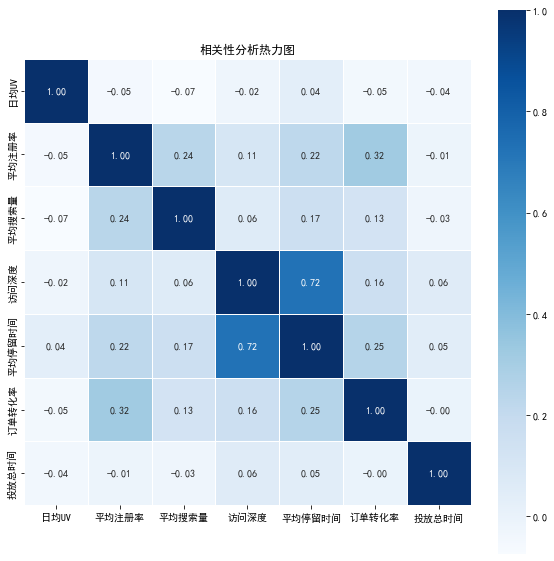

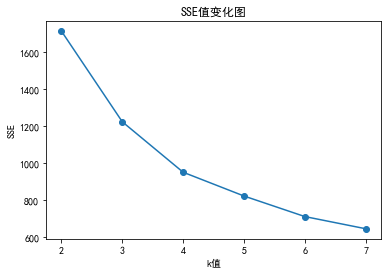

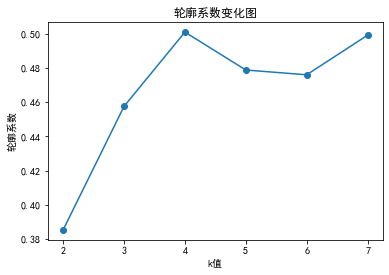

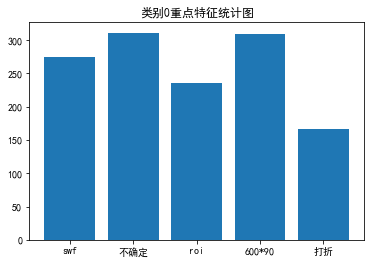

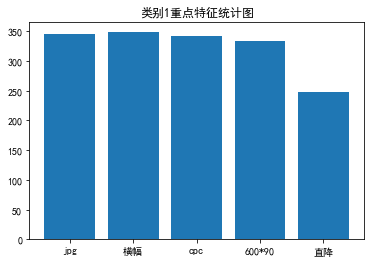

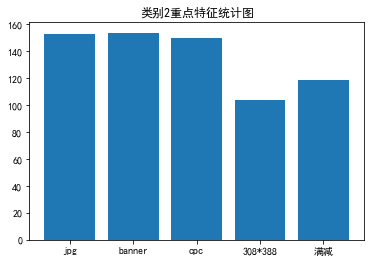

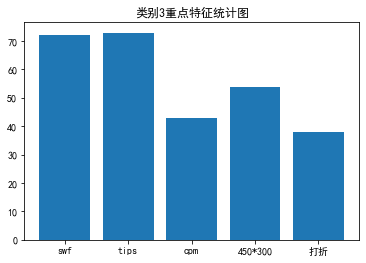

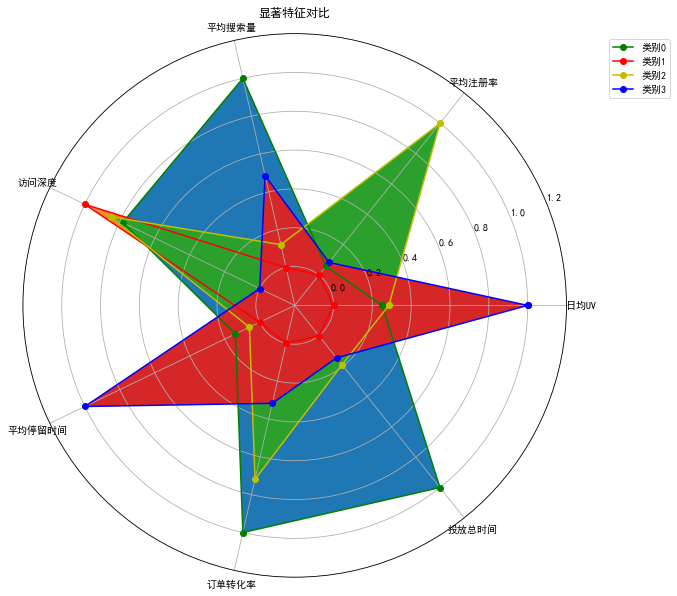

In [1]:
'''导入所需包 '''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
 
'''缺失值处理'''
'''读入数据'''
ad = pd.read_csv(r'ad_performance.csv')
ad = ad.iloc[:,1:]
 
'''检查缺失值'''
# print(ad.isnull().sum())
'''删除缺失值'''
ad.dropna(axis=0, inplace=True)
# print(ad.isnull().sum())
 
 
'''相关性分析'''
def heatmap():
    corr = ad.corr()
    plt.rcParams["font.sans-serif"] = ["SimHei"]  # 设置中文
    plt.rcParams['axes.unicode_minus'] = False  # 解决符号不显示问题
    fig = plt.figure(figsize=(10 , 10))
    ax = fig.add_subplot(111)
    ax.set_title('相关性分析热力图')
    sns.heatmap(corr, cbar=True, square=True, fmt='.2f', annot=True,
                annot_kws={'size': 10}, ax=ax, cmap='Blues',linewidths=1)
    plt.savefig('./heatmap.jpg')
    plt.show()
 
 
'''数据编码与标准化'''
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
def one_hot():
    '''两种方法对后面的无序型离散特征变量进行处理'''
    '''第一种pandas中的get_dummies方法,该方法默认会对DataFrame中所有字符串类型的列进行独热编码'''
    # after_onehot = pd.get_dummies(ad[['素材类型','广告类型','合作方式','广告尺寸','广告卖点']],drop_first=True)
 
 
    '''第二种，先用LabelEncoder()方法映射为数值，再将整数型数值进行独热编码'''
    data = ad[['素材类型','广告类型','合作方式','广告尺寸','广告卖点']].values
    encoder = LabelEncoder()
    for i in range(data.shape[1]):
        data[:,i] = encoder.fit_transform(data[:,i])
 
    onehot = OneHotEncoder(sparse=True)
    after_onehot = onehot .fit_transform(data).toarray()
    return  after_onehot
#
'''归一化'''
 
def normalize(_data):
    max = _data.max(axis=0)
    min = _data.min(axis=0)
    m = _data.shape[0]
    after_normalize = _data - np.tile(min, (m, 1))
    after_normalize = after_normalize / np.tile((max - min), (m, 1))
    return after_normalize
 
 
 
'''建立KMeans聚类模型'''
'''首先选定K，这里采用手肘法计算和轮廓系数法一起判断'''
def choose_k(all_data):
    SSE_list=[]
    #利用手肘法来确定K值,求SSE误差平方和,当曲线不再急剧下降时,就是最好的k值
    for k in range(2,8):
        _kmeans = KMeans(n_clusters=k)#构造聚类器
        _kmeans.fit(all_data)#聚类
        SSE_list.append(_kmeans.inertia_ )# 获取聚类准则的总和
    plt.plot(range(2,8),SSE_list,'o-')
    plt.title('SSE值变化图')
    plt.xlabel('k值')
    plt.ylabel('SSE')
    plt.savefig('./SSE.jpg')
    plt.show()
 
    #轮廓系数法
    from sklearn.metrics import silhouette_score
    silhouette_list=[]
    for k in range(2,8):
        kmeans_ = KMeans(n_clusters=k)#构造聚类器
        kmeans_.fit(all_data)
        silhouette_list.append(silhouette_score(all_data,kmeans_.labels_))
    plt.plot(range(2,8),silhouette_list,'o-')
    plt.title('轮廓系数变化图')
    plt.xlabel('k值')
    plt.ylabel('轮廓系数')
    plt.savefig('./Silhouette Coefficient.jpg')
    plt.show()
 
'''得出K选定为4'''
'''代入4训练模型'''
def kmeans(_all_data):
    k=4
    _kmeans = KMeans(n_clusters=k,n_init=15,max_iter=500)
    #开始聚类训练
    _kmeans.fit(_all_data)
    # 获取聚类标签
    label_pred = np.array(_kmeans.labels_)
 
    count_type = pd.Series(label_pred).value_counts()#得到各个类别的个数
 
    # 把得到的类别添加到原来的数据
    with_type = pd.concat([ad, pd.Series(label_pred, index=ad.index)], axis=1)
    with_type.columns = list(ad.columns) + [u'聚类结果']
    with_type.to_csv('result_all_data.csv',encoding='utf-8')#写入csv文件
    return with_type
 
'''对模型结果进行分析总结并写入csv'''
'''找出每个类别的重点特征，后面的字符型特征就用每类的众数来表示重点特征'''
'''前面的数值型特征就用平均数当重点特征，这儿也主要是为了方便画雷达图'''
def get_features(_result):
    columns = _result.columns[1:-1]
    all = []
    for type in range(4):  # 读取每个类索引
        mean = []
        mode = []
        mode_count = []
        label_data = _result[_result['聚类结果'] == type]
        data1 = label_data.iloc[:, 1:8]#数值型特征
        for i in range(data1.shape[1]):
            mean.append(data1.iloc[:, i].mean(axis=0))#算均值
        _data1 = pd.Series(mean)#转成series方便后面连接
 
        data2 = label_data.iloc[:, 8:-1]#字符型特征
        for i in range(data2.shape[1]):
            x = pd.Series(data2.iloc[:, i]).value_counts()#计数，返回值自动按从大到小顺序排列好的
            mode.append(x.index[0])#取出第一个数，即最多得那个数
            mode_count.append(x[0])
        _data2 = pd.Series(mode)
        plt.bar(mode, mode_count)#画条形统计图统计每个类的重点特征和数量
        plt.title('类别'+str(type)+'重点特征统计图')
        plt.show()
 
        single_type_data = pd.concat((_data1, _data2), axis=0)
        single_type_data.index = columns  # 因为得到的数据没索引，所以要添加索引
        all.append(single_type_data)
    all_to_pd = pd.DataFrame(all)
    # 因为上面的判断条件就是按照0，1，2，3的顺序来读的数据，所以加类别直接安顺序0，1，2，3加上去
    tocsv = pd.concat([all_to_pd, pd.Series([0, 1, 2, 3])], axis=1)
    tocsv.columns = list(all_to_pd.columns) + [u'聚类结果']
    tocsv.to_csv('result.csv',encoding='utf-8')#写入csv文件
 
    return all_to_pd
 
'''可视化展示'''
def visualization(_result1):
    vis_data = _result1.iloc[:, :7]#得到各个类的数值型特征
    after_normalize_vis_data = normalize(vis_data).values#将这些数据进行归一化
 
    plt.rcParams["font.sans-serif"] = ["SimHei"]  # 设置中文
    plt.rcParams['axes.unicode_minus'] = False  # 解决符号不显示问题
 
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, polar=True)
    labels = np.array(_result1.columns[:7])
    cor_list = ['g', 'r', 'y', 'b']
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))
 
    for i in range(len(vis_data)):
        data_tmp = after_normalize_vis_data[i, :]
        data = np.concatenate((data_tmp, [data_tmp[0]]))
        ax.plot(angles, data, 'o-', c=cor_list[i], label="类别%d"%(i))
        ax.fill(angles, data,alpha=1.0)
 
    angles = angles * 180 / np.pi
    ax.set_thetagrids(angles[:-1], labels)
    ax.set_title("显著特征对比")
    ax.set_rlim(-0.2, 1.2)
    plt.legend(loc="upper right" ,bbox_to_anchor=(1.2,1.0))
    plt.savefig('./result_visualization.jpg')
    plt.show()
 
heatmap()
data = ad.iloc[:,1:8]#不要第一列的渠道代号
after_normalize = normalize(data)#得到归一化后的数据
#将归一化后的数值型特征和独热编码后的字符型特征连接起来
all_data = np.hstack((after_normalize.values, one_hot()))
choose_k(all_data)#通过分析得到K
result = kmeans(all_data)
result1 = get_features(result)
visualization(result1)